<a href="https://colab.research.google.com/github/viswambhar-yasa/image_captioning/blob/master/training_reward_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image captioning using reinforcement learning
### Policy to actor method on deep convolution and recurrent networks
#### Project Seminar for artifical intelligence WS2021-22
##### Authors : Viswambhar Yasa, Venkata Mukund 




###### Cloning github repo



In [ ]:
!git clone https://github.com/viswambhar-yasa/image_captioning

Cloning into 'image_captioning'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 46 (delta 20), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [ ]:
cd /content/image_captioning

/content/image_captioning


###### Importing flickr data from url 

In [ ]:
from data_extraction import downloading_extraction

In [ ]:
images_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
downloading_extraction(images_link)
text_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
downloading_extraction(text_link)

##### importing deep convolution: encoder and decoder




In [ ]:
from model_networks import Caption_model_gen

In [ ]:
import tensorflow as tf

In [ ]:
from data_processing import data_processing

##### Extracting captions of the images and creating a dictionary with image id as key and captions as values

In [ ]:
captions_path=r"/content/image_captioning/Flickr8k.token.txt"

In [ ]:
text = open(captions_path, 'r', encoding='utf-8').read()
description_map=dict()
# splitting list based on newline and tab
for lines in text.split('\n'):
  line_split = lines.split('\t')
  if line_split == ['']:
      continue
  image_id = line_split[0][:-2]
  image_des = line_split[1]
  #if image_id in img_dic:
  if image_id not in description_map:
    description_map[image_id] = list()
  description_map[image_id].append(image_des)
caption_list = []

#mapping captions as dictionary
for img_id, des_list in description_map.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        caption = ''.join(caption)
        caption = caption.split(' ')
        caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
        caption = ' '.join(caption)
        des_list[i] = 'startseq ' + caption + ' endseq'
        caption_list.append('startseq ' + caption + ' endseq')
max_length = max(len(des.split()) for des in caption_list)
print('max_length of captions', max_length)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8360,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

max_length of captions 33


In [ ]:
images_path=r"/content/image_captioning/Flicker8k_Dataset"

In [ ]:
import os
files=os.listdir(path = images_path)

In [ ]:
description_map1=dict()
for key,value in description_map.items():
  if key in files:
    description_map1[key]=value

In [ ]:
description_map['2258277193_586949ec62.jpg'] = description_map['2258277193_586949ec62.jpg.1']
del description_map['2258277193_586949ec62.jpg.1']

In [ ]:
del description_map['2258277193_586949ec62.jpg']

##### Performing tokenization : converting words to tokens



In [ ]:
token_cap_dic = dict()
print('Vocab size',len(tokenizer.word_counts))
for img_id, des_list in description_map1.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        cap_token = tokenizer.texts_to_sequences([str(caption)])
        if img_id not in token_cap_dic:
            token_cap_dic[img_id] = list()
        token_cap_dic[img_id].append(cap_token)

Vocab size 8359


###### importing manual loss function and cosine distance required for training reward net

In [ ]:
from model_losses import reward_net_loss,loss,Rewards,cos

In [ ]:
from data_generator import captions_generation_reward

##### Creating training, validation and test datasets

In [ ]:
import pickle

print('TensorFlow Version', tf.__version__)
vocab_size = 8360
max_length = 25


captions_text_path = r'/content/image_captioning/Flickr8k.token.txt'
captions_extraction = data_processing(captions_text_path)
trn_images_id_text = r'/content/image_captioning/Flickr_8k.trainImages.txt'
train_cleaned_seq, train_cleaned_dic = captions_extraction.cleaning_sequencing_captions(trn_images_id_text)
val_images_id_text = r'/content/image_captioning/Flickr_8k.devImages.txt'
val_cleaned_seq, val_cleaned_dic = captions_extraction.cleaning_sequencing_captions(val_images_id_text)
test_images_id_text = r'/content/image_captioning/Flickr_8k.testImages.txt'
test_cleaned_seq, test_cleaned_dic = captions_extraction.cleaning_sequencing_captions(test_images_id_text)
captions_extraction.tokenization(train_cleaned_seq, vocab_size)
print("No of captions: Training-" + str(len(train_cleaned_seq) / 5) + " Validation-" + str(
    len(val_cleaned_seq) / 5) + " test-" + str(len(test_cleaned_seq) / 5))

train_cap_tok = captions_extraction.sentence_tokenizing(train_cleaned_dic)
val_cap_tok = captions_extraction.sentence_tokenizing(val_cleaned_dic)
test_cap_tok = captions_extraction.sentence_tokenizing(test_cleaned_dic)

image_pth_rt = r"/content/image_captioning/Flicker8k_Dataset/" #+ r"\\"
trn_dataset = captions_generation_reward(train_cap_tok, vocab_size, image_pth_rt, 15,2,1)
val_dataset = captions_generation_reward(val_cap_tok, vocab_size, image_pth_rt, 25,32,1)

inputs = next(iter(val_dataset))
print(inputs[0].shape, inputs[1].shape)  

TensorFlow Version 2.8.0
max_length of captions 33
max_length of captions 31
max_length of captions 30
No of captions: Training-6000.0 Validation-1000.0 test-1000.0
Vocab size 8360
Vocab size 8360
Vocab size 8360
(32, 256, 256, 3) (32, 25)


In [ ]:
trn_dataset_whole = captions_generation_reward(token_cap_dic, 8360, image_pth_rt, max_length=25,num_photos_per_batch=32,num_captions=1)

#### Building policy net and adding optimizer, loss function, evaluation metrics


In [ ]:
#actor_model.load_weights('/content/drive/MyDrive/Kaggle/policy_net_weights_xception.h5')

In [ ]:
reward_model = Caption_model_gen(NET='reward', vocab_size=8360, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image feature vector shape: (None, 512)
Text sequence vector shape: (None, 512)
Reward Net built successfully 



In [ ]:
visuals=tf.ones((1,512))
semantics=tf.ones((1,512))

In [ ]:
loss(visuals,semantics)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
#reward_model1=tf.keras.models.load_model('/content/drive/MyDrive/Kaggle/reward_net.h5')

In [ ]:
#reward_model.save('/content/drive/MyDrive/Kaggle/reward_net.h5')

#### Training model on training dataset

In [ ]:
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
history={}
history['loss']=list()
history['val_loss']=list()
metrics_names = ['loss'] 
epochs = 1
num_epoch=200
for i in range(epochs):
    n=0
    epoch=0
    for step, x_batch_train in enumerate(trn_dataset_whole):
        if epoch==num_epoch:
          break
        progbar = tf.keras.utils.Progbar(10,stateful_metrics=['loss'])
        with tf.GradientTape() as tape:
            [visual,sematic] = reward_model(x_batch_train, training=True)  # Logits for this minibatch0
            loss_value = loss(visual, sematic)
        grads = tape.gradient(loss_value, reward_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, reward_model.trainable_weights))
        progbar.update(n, values = [("loss", loss_value)])
        # Log every 200 batches.
        n+=1
        #if loss_value < 0.05:
        #  break
        if step % 10 == 0:
            epoch+=1
            val_ds=next(iter(val_dataset))
            [val_visual,val_sematic] = reward_model(val_ds)
            val_loss_value=loss(val_visual, val_sematic)
            progbar.add(1,values = [("val_loss", val_loss_value)])
            n=0
            print("\nepoch %d" % (epoch,))
            history['loss'].append(loss_value)
            history['val_loss'].append(val_loss_value)

 1/10 [==>...........................] - ETA: 7s - loss: 34.2772 - val_loss: 12.4473
epoch 1
10/10 [==============================] - 1s 78ms/step - loss: 26.7345 - val_loss: 11.8350

epoch 2
10/10 [==============================] - 1s 77ms/step - loss: 19.1982 - val_loss: 11.9315

epoch 3
10/10 [==============================] - 1s 78ms/step - loss: 19.9993 - val_loss: 12.3894

epoch 4
10/10 [==============================] - 1s 77ms/step - loss: 16.0164 - val_loss: 11.6624

epoch 5
10/10 [==============================] - 1s 78ms/step - loss: 12.2609 - val_loss: 11.9714

epoch 6
10/10 [==============================] - 1s 77ms/step - loss: 14.5060 - val_loss: 10.4711

epoch 7
10/10 [==============================] - 1s 78ms/step - loss: 9.5881 - val_loss: 10.3005

epoch 8
10/10 [==============================] - 1s 78ms/step - loss: 12.1093 - val_loss: 9.9198

epoch 9
10/10 [==============================] - 1s 76ms/step - loss: 12.8508 - val_loss: 11.1361

epoch 10
10/10 [==========

#### Saving model history and weight

In [ ]:
f = open("/content/final_reward_net_whole_training_lstm_bi_loss.pkl", "wb")
pickle.dump(history, f)
f.close()   

In [ ]:
model_hist=open("/content/final_reward_net_whole_training_lstm_hard_loss.pkl", "wb")

In [ ]:
import matplotlib.pyplot as plt

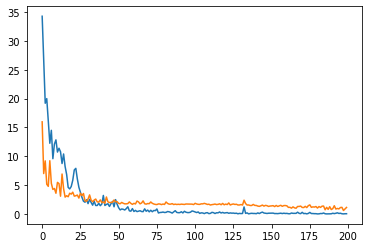

In [ ]:
plt.plot(history['loss'])
plt.plot(model_hist['loss'])
#plt.plot(history['val_loss'])
#plt.axis([150,400,0,5])

In [ ]:
#reward_model.save_weights('/content/drive/MyDrive/Kaggle/final_reward_net_weights_all.h5')

In [ ]:
#reward_model.save('/content/drive/MyDrive/Kaggle/reward_net_weights.h5')

In [ ]:
inputs1 = next(iter(val_dataset))

print(inputs[0].shape, inputs1[1].shape)

(25, 256, 256, 3) (25, 25)


In [ ]:
Rewards(reward_model,[inputs[0], inputs[1]])

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([ 0.02177213,  0.09168981,  0.05719122,  0.07145166,  0.08618225,
        0.15175845,  0.15766758,  0.00541286, -0.03181414, -0.02004794,
       -0.08428244,  0.03512927,  0.14939623,  0.04865621, -0.00354678,
        0.09814619,  0.12125899,  0.15942904,  0.14223643,  0.06877327,
        0.12730028,  0.07815305,  0.07971337,  0.08816956,  0.0481442 ],
      dtype=float32)>

In [ ]:
#reward_model.save('/content/drive/MyDrive/Kaggle/reward_net.h5')

In [ ]:
inputs = next(iter(val_dataset))
inputs_1 = next(iter(val_dataset))
print(inputs[0].shape, inputs[1].shape)

(25, 256, 256, 3) (25, 25)


Text(0.5, 1.0, '[[   2   16 1053 1457   65 1705   35  246  105   81    3    0    0    0\n     0    0    0    0    0    0    0    0    0    0    0]]')

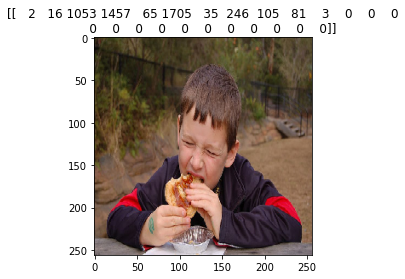

In [ ]:
plt.imshow(tf.squeeze(inputs_1[0]))
plt.title(str(inputs_1[1]))

In [ ]:
r=Rewards(reward_model,[inputs[0], inputs_1[1]])
print(r)

tf.Tensor([0.01224614], shape=(1,), dtype=float32)


In [ ]:
'/content/drive/MyDrive/Kaggle/reward_net.h5'

'/content/drive/MyDrive/Kaggle/reward_net.h5'

In [ ]:
history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
f = open("/content/history_reward_model_Adam_incp_lstm_3.pkl", "wb")
pickle.dump(history, f)
f.close() 

In [ ]:
reward_model.save_weights('/content/reward_net_model_weights.h5')